# Linear and Quadratic Discriminant Analysis (LDA, QDA, RDA)

In [1]:
%matplotlib notebook
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn.metrics as metrics
from scipy.spatial import Voronoi, voronoi_plot_2d
from numpy.testing import assert_array_almost_equal
import ipywidgets as wd

# Theoretical Framework

Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space and let $X$ be a $d$-dimensional real random variable and $Y$ be discrete, i.e. we assume that $Y$ can only take finitely many values $0, 1, \ldots, K-1$ called *classes*. We are given some labelled data set $(\mathcal{X},\mathcal{y})=(\mathcal{X}_i,\mathcal{y}_i)_{i=1, \ldots, N}$ and want to predict for any $x^* \in \mathbb{R}^d$ the class $\hat y=\hat F(x)$ it belongs to. Using the standard decision science framework, we do this by
\begin{align*}
    \hat y = \operatorname{argmax}_k\mathbb{P}[Y=k \mid X=x^*].
\end{align*}

For any $x^* \in \mathbb{R}^d$, the later probability is given by the Bayes formula as
\begin{align*}
    \mathbb{P}[Y=k \mid X=x^*] = \frac{\mathbb{P}[X=x^* \mid Y=k]}{\mathbb{P}[X=x]} \mathbb{P}[Y=k].
\end{align*}
Notice that the marginal likelihood $\mathbb{P}[X=x]$ does not depend on $k$ and hence is irrelevant for the purpose of calculating the $\operatorname{argmax}$ above. 

## Assumptions
Disciminant Analysis now takes two slightly different flavours depending on the assumptions on the likelihood. Both assume that $X \mid Y=k$ has a multivariate Gaussian distribution and for

**1. Linear Discrimminant Analysis (LDA):** We assume in addition that there exists one covariance matrix $\Sigma$ and $K$ mean vectors $\mu_0, \ldots, \mu_{K-1}$, such that for all classes $k=0, \ldots, K-1$, 
\begin{align*}
    X \mid Y=k \sim \mathcal{N}(\mu_k, \Sigma),
\end{align*}
i.e. we assume that all classes have the same conditional covariance.

**2. Quadratic Discriminant Analysis (QDA):** We assume that for each class $k=0, \ldots, K-1$ there exists a mean vector $\mu_k$ and a covariance matrix $\Sigma_k$ such that
\begin{align*}
    X \mid Y=k \sim \mathcal{N}(\mu_k, \Sigma_k),
\end{align*}
i.e. we allow different covariance matrices for different classes.
Denoting by 
\begin{align*}
    \varphi_{\mu,\Sigma}:\mathbb{R}^{d} \to \mathbb{R}, && x \mapsto (2\pi)^{-\tfrac{d}{2}} \det(\Sigma)^{-\tfrac{1}{2}} \exp(-\tfrac{1}{2}(x-\mu)^\top \Sigma^{-1}(x-\mu))
\end{align*}
the density of the $d$-dimensional Gaussian distribution of mean $\mu$ and covariance $\Sigma$, the discriminant analysis classifier is defined by 
\begin{align*}
    \hat F:\mathbb{R}^d \to \{0, 1, \ldots, K-1\}, && 
    x \mapsto \operatorname{argmax}_k \varphi_{\mu_k, \Sigma_k}(x) \pi_k,
\end{align*}
where $\pi_k := \mathbb{P}[Y=k]$ is the prior. For LDA all the $\Sigma_k$ are the same matrix $\Sigma$ and for QDA these matrices may be different.

**3. Regularized Discriminant Analysis (RDA):** This is a flavour of QDA that mixes the covariance matrices $\Sigma_k$ of the classes from QDA with the pooled covariance matrix $\Sigma$ from LDA via a parameter $\alpha \in [0,1]$, i.e. it is QDA, but with the covariance matrices
\begin{align*}
    \Sigma_k(\alpha) := \alpha \Sigma_k + (1-\alpha)\Sigma.
\end{align*}

# Properties 
The QDA and LDA classifier have some nice properties

## Discriminant Functions
**Theorem**: For any $x \in \mathbb{R}^d$ The QDA and LDA classifier with means $\mu_k \in \mathbb{R}^d$, $k=0, \ldots, K-1$, and covariances $\Sigma_k \in \mathbb{R}^{d \times d}$, respectively, covariance $\Sigma \in \mathbb{R}^{d\times d}$, can be calculated equivalently via
\begin{align*}
    \hat F(x) = \operatorname{argmax}_k \delta_k(x),
\end{align*}
where in case of the QDA classifier
\begin{align*}
    \delta_{k}(x) := - \frac{1}{2} (x-\mu_k)^\top \Sigma_k^{-1}(x-\mu_k) -\frac{1}{2} \log(\det(\Sigma_k))  + \log(\pi_k)
\end{align*}
is the *quadratic discriminant* and in case of the LDA classifier
\begin{align*}
    \delta_{k}(x) := x^\top \Sigma^{-1} \mu_k + \frac{1}{2}\mu_k^{\top}\Sigma^{-1} \mu_k + \log(\pi_k)
\end{align*}
is the *linear discrminant*. 

**Proof:** Instead of calculating which class maximizes $\varphi_{\mu_k, \Sigma_k}(x) \pi_k$ we can equivalently calculate the class that maximizes the $\log$ of that expression, since $\log$ is a non-decreasing function. Hence, for the QDA, we calculate
\begin{align*}
    \log(\varphi_{\mu_k,\Sigma_k}(x)\pi_k)=\underbrace{-\tfrac{d}{2}\log(\pi)}_{\text{does not depend on }k} - \underbrace{\tfrac{1}{2} \log(\det(\Sigma_k)) - \tfrac{1}{2} (x-\mu_k)^\top \Sigma_k^{-1}(x-\mu_k) + \log(\pi_k)}_{=\delta_k(x)}.
\end{align*}
For the LDA, we calculate
\begin{align*}
    \log(\varphi_{\mu_k,\Sigma_k}(x)\pi_k)=\underbrace{-\tfrac{d}{2}\log(\pi) - \tfrac{1}{2} \log(\det(\Sigma)) -\tfrac{1}{2}x^\top \Sigma^{-1}x}_{\text{does not depend on }k} + \underbrace{x^\top \Sigma^{-1} \mu_k - \frac{1}{2}\mu_k^{\top}\Sigma^{-1} \mu_k + \log(\pi_k)}_{=\delta_k(x)}.
\end{align*}

\begin{array}{r}\Box\end{array}

## Decision Boundary
The LDA has a particularly nice decision boundary.

**Theorem:** For any two classes $k$ and $l$, the decision boundary of the LDA satisfies the affine linear equation
\begin{align*}
    \Gamma_{kl} &:= \{x \in \mathbb{R}^d \mid \delta_k(x)=\delta_l(x) \} \\
                &= \Big\{x \in \mathbb{R}^d \mid (x-m_{kl} + \bar \pi_{kl})^\top \bar v_{kl} = 0  \Big\},
\end{align*}
where
\begin{align*}
    m_{kl} := \frac{1}{2}(\mu_k + \mu_l), &&
    v_{kl} := \mu_k - \mu_l, &&
    \bar v_{kl} := \Sigma^{-1}v_{kl}, &&
    \bar \pi_{kl} := \log\Big( \frac{\pi_k}{\pi_l} \Big) \frac{\bar v_{kl}}{\bar v_{kl}^\top \bar v_{kl}}.
\end{align*}

**Proof:** We calculate
\begin{align*}
    \log(\varphi_{\mu_k,\Sigma}(x) \pi_k) = \log(\varphi_{\mu_k,\Sigma}(x) \pi_l)
    & \Longleftrightarrow
    \delta_k(x) = \delta_l(x) \\
    & \Longleftrightarrow
    x^\top \Sigma^{-1}(\mu_k-\mu_l) - \frac{1}{2}(\mu_k+\mu_l)^{\top}\Sigma^{-1}( \mu_k - \mu_l) +  \log\Big(\frac{\pi_k}{\pi_l}\Big)  = 0 \\
    & \Longleftrightarrow
    (x - m_{kl})^\top \bar v_{kl} +  \log\Big(\frac{\pi_k}{\pi_l}\Big)  = 0,
\end{align*}
which implies the claim.
\begin{array}{r}\Box\end{array}

## Geometric Interpretation
This theorem has a nice geometric interpretation: Assuming unit covariance and a uniform prior, i.e. $\bar \pi_{kl}=0$ and $\Sigma=I$, this means that the decision boundary of the LDA is the affine hyperplane orthogonal to $v_{kl}= \mu_k - \mu_l$, i.e. the vector that connects the class centroids $\mu_k$ and $\mu_l$ translated to $m_{kl}$, i.e. the midpoint between the class centroids. 

If the prior is not uniform, then the midpoint is adjusted along that connecting line. This is what gives LDA the name *linear*. Analogously, the decision boundaries of QDA are quadratic equations.

## Sphering
If the covariance matrix $\Sigma$ is not the unit matrix, then one option is to simply replace $v_{kl} = \mu_k - \mu_l$ by $\bar v_{kl} = \Sigma^{-1}v_{kl}$, however in practice one often chooses an alternative option based on the following.

**Lemma:** Let $X = (X_1, \ldots, X_d)$ be an $L^2$ random variable with mean vector $\mu \in \mathbb{R}^d$ and covariance matrix $\Sigma$. Let $\Sigma = U D U^{\top}$ be the eigendecomposition of $\Sigma$, i.e. $U$ is orthonormal and $D$ is diagonal. Then $X^* := D^{-\tfrac{1}{2}} U^{\top} X$, the *sphering of $X$*, has unit covariance and mean $\mu^* := D^{-\tfrac{1}{2}} U^{\top} \mu$.

**Proof:** The eigendecomposition of $\Sigma$ exists because $\Sigma$ is symmetric positive definite. Hence the claim follows simply from the properties of the covariance operator:
\begin{align*}
    \operatorname{Cov}[X^*] 
    = D^{-\tfrac{1}{2}} U^{\top} \Sigma D^{-\tfrac{1}{2}} U
    = D^{-\tfrac{1}{2}} U^{\top} U D U^{\top} D^{-\tfrac{1}{2}} U
    =I.
\end{align*}
\begin{array}{r}\Box\end{array}

## Relationship with Voronoi Diagrams
Let us assume the data is already sphered, i.e. it has unit covariance, and let $\mu_k^*$ and $\mu_l^*$ be the sphered class centroids. Furthermore, assume that the prior is uniform, hence $\log(\tfrac{\pi_k}{\pi_l})=0$. If $k$ and $l$ are the only two classes, then by the above theorem, the decision boundary between $k$ and $l$ is simply the perpendicular bisector between the sphered class centroids $\mu_k^*$ and $\mu_l^*$ by our above theorem. Hence, the set $V_k \subset \mathbb{R}^d$ of all input data points $x^*$ that is classified to $k$ is the half plane $H_k(l)$ cut by the bisector between $\mu_k^*$ and $\mu_l^*$. If there are more than two classes, then
\begin{align*}
    V_k = \bigcap_{l\neq k}{H_k(l)},
\end{align*}
i.e. the region $V(k)$ of all points $x^*$ classified as $k$ is the intersection of all half planes defined by the perpendicular bisectors connecting the sphered centroids. Or in other words, the various $V(k)$ are the [*Voronoi diagram*](https://en.wikipedia.org/wiki/Voronoi_diagram) of the sphered class cenroids $\mu_k^*$, $k=0, \ldots, K-1$. For any given set of points $p_k$, the *Voronoi region* associated with $k$ is the set of all points for which $p_k$ is closer than all other points $p_l$, i.e.
\begin{align*}
    V(p_k) = \{x \in \mathbb{R}^d \mid \forall l \neq k: \|x-p_k\| \leq \|x-p_l\| \}.
\end{align*}
[Is it known](https://www.cse.iitk.ac.in/users/amit/courses/RMP/presentations/kshitij/index.html) that the Voronoi cell can be written as the intersection of the bisectors between the various points. Hence, we can alternatively calculate the decision boundaries and resulting regions of an LDA by calculating the Voronoi diagram of the sphered centroids as
\begin{align*}
    V_k = V(\mu_k^*).
\end{align*}

## Calculations
The sphering can also be used to simplify the calculations needed to apply LDA or QDA classifiers in practice.

Given the input data $(\mathcal{X},\mathcal{y})=(\mathcal{X}_i,\mathcal{y}_i)_{i=1, \ldots, N}$ and a new data point $x$, its label can be calculated as follows:

**QDA:**
1. Fitting: For each class $k=0, \ldots, K-1$:
* estimate the priors $\hat \pi_k := \frac{N_k}{N}$, where $N_k := \{i \mid y_i = k\}$.
* estimate the class centroids $\hat \mu_k := \frac{1}{N_k} \sum_{i,y_i=k}{x_i}$
* estimate the class covariance matrix $\hat \Sigma_k := \frac{1}{N_k-1}\sum_{i,y_i=k}{(x_i-\hat \mu_k)(x_i-\hat \mu_k)^\top}$
* calculate the eigendecomposition $\hat \Sigma_k = U_k D_k U_k^{\top}$
* calculate the log determinant $\log(\det(\hat \Sigma_k)) = \sum_{l=1}^d{\log(D_{kl})}$

2. Prediction: For the new data point $x \in \mathbb{R}^d$
* calculate the quadratic discriminants $\delta_k(x) =  - \frac{1}{2} (U^\top(x-\mu_k))^\top D_k^{-1} (U(x-\mu_k)) -\frac{1}{2} \log(\det(\Sigma_k))  + \log(\pi_k)$
* calculate the label $\hat y = \operatorname{argmax}_k{\delta_k(x)}$.

**LDA:**
1. Fitting: 
* For each class $k=0, \ldots, K-1$ estimate the priors $\hat \pi_k := \frac{N_k}{N}$, where $N_k := \{i \mid y_i = k\}$.
* For each class $k=0, \ldots, K-1$ estimate the class centroids $\hat \mu_k := \frac{1}{N_k} \sum_{i,y_i=k}{x_i}$
* Estimate the pooled covariance matrix $\hat \Sigma := \sum_{k=0}^{K-1}{\frac{1}{N - K}\sum_{i,y_i=k}{(x_i-\hat \mu_k)(x_i-\hat \mu_k)^\top}}$.
* Calculate the eigendecomposition $\hat \Sigma = U_k D_k U_k^{\top}$
* calculate the log determinant $\log(\det(\hat \Sigma)) = \sum_{l=1}^d{\log(D_{l})}$
* calculate the sphered means $\mu^* := D^{-\tfrac{1}{2}}U^{\top}\mu$

2. Prediction: For the new data point $x \in \mathbb{R}^d$
* sphere the data point via $x^* := D^{-\tfrac{1}{2}}U^{\top}x$
* calculate the linear discriminants in sphered space $\delta_k^*(x) = (x^*)^{\top} \mu_k^*  + \frac{1}{2}(\mu_k^*)^{\top} \mu_k^* + \log(\pi_k)$
* calculate the label $\hat y = \operatorname{argmax}_k{\delta_k^*(x)}$.

# Examples

## Linear Discriminant Analysis (LDA)

### Generate Data

In [2]:
# set parameters
n = 100
mu = [np.array([-3, 0]), 
      np.array([3, 5]), 
      np.array([4, -4])]
sigma = [1, 1, 1]
rho = [0.5, 0.5, 0.5]
cov = [np.array([[1,r],[r,1]])*s for r,s in zip(rho,sigma)]

# generate data
np.random.seed(2)
x = [ss.multivariate_normal(mean=m, cov=c).rvs(size=n) for m,c in zip(mu,cov)]
means_empiric = [xx.mean(axis=0) for xx in x] # for later validation
cov_empiric = [np.cov(xx.T, bias=True) for xx in x]
X = np.vstack(x)
y = np.hstack([np.ones(n)*0, np.ones(n)*1, np.ones(n)*2]).astype(int)

### Set up model and fit

In [3]:
lda = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
lda.fit(X,y)

LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)

### Generate some new data for predictions

In [4]:
x_pred = np.array([[-2, 1], 
                   [0.5, 5], 
                   [4, -1], 
                   [0.3, 0.8]])

### Reconlie LDA calculations

In [5]:
# means
assert_array_almost_equal(lda.means_, means_empiric)

# priors
priors = np.array([ (y==i).sum() for i in range(3) ]) / X.shape[0]
assert_array_almost_equal(lda.priors_, priors)

# weighted covariance
cov_weighted = np.array([cov_empiric[i] * lda.priors_[i] for i in range(3)]).sum(axis=0)
assert_array_almost_equal(lda.covariance_, cov_weighted) # (n_classes, n_features)

# Sigma^{-1} mu_k
assert_array_almost_equal(lda.coef_, (np.linalg.inv(lda.covariance_)@lda.means_.T).T) # (n_classes, n_features)

# -1/2 * mu_k^T * Sigma^{-1}mu_k + log(\pi_k)
assert_array_almost_equal(lda.intercept_, 
                          np.array([- lda.means_[k,:].T @ np.linalg.inv(lda.covariance_) @ lda.means_[k,:] /2 + np.log(priors[k])
                                    for k in range(3)]))

# linear discriminant: log(P[y=k \mid x] = delta_k(x)
assert_array_almost_equal(lda.decision_function(x_pred),  # (n_test, n_classes)
                          (lda.coef_ @ x_pred.T).T + lda.intercept_)

# class prediction as argmax
assert_array_almost_equal(lda.predict(x_pred),  # (n_test, n_classes)
                          np.argmax(lda.decision_function(x_pred), axis=1))

### Plot results

In [6]:
D, S = np.linalg.eig(lda.covariance_)
A = np.diag(1/np.sqrt(D)) * S.T
x_sphered = [(A @ xk.T).T for xk in x ] 
mu_sphered = [A @ muk for muk in mu]

<IPython.core.display.Javascript object>


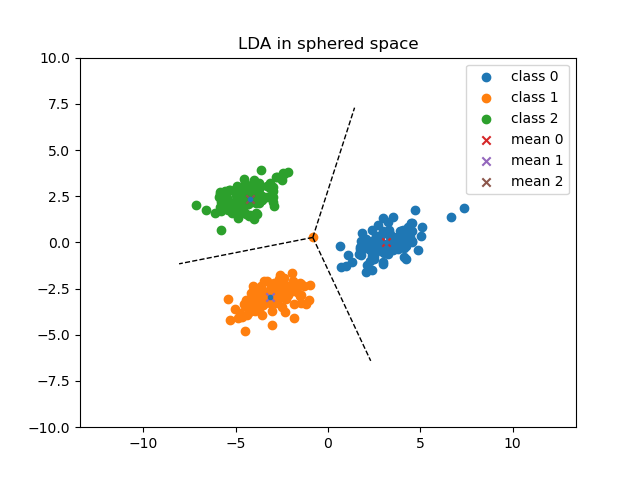

In [7]:
plt.figure()
plt.title('LDA in sphered space')
plt.axis('equal')

# plot sphered points
for i, xk in enumerate(x_sphered):
    plt.scatter(xk[:, 0], xk[:, 1], label=f'class {i}')

# plot sphered centroids
for i, muk in enumerate(mu_sphered):
    plt.scatter(muk[0], muk[1], marker='x', label=f'mean {i}')

# manually plot decision boundaries
#l = 10
#for i in range(2):
#    for j in range(i+1, 3):
#        a = mu_sphered[i]
#        b = mu_sphered[j]
#        m = (a+b)/2
#        v = b-a
#        v[0], v[1] = -v[1], v[0]
#        v = v / np.linalg.norm(v)
#        plt.plot(np.array([m[0]-l*v[0], m[0]+l*v[0]]),
#                 np.array([m[1]-l*v[1], m[1]+l*v[1]]),
#                label=f'boundary {i} | {j}')

# can use Voronoi diagram to show decition boundaries
vor = Voronoi(mu_sphered)
voronoi_plot_2d(vor, ax=plt.gca())

plt.xlim([-10,10])
plt.ylim([-10,10])


plt.legend()
plt.show()

<IPython.core.display.Javascript object>


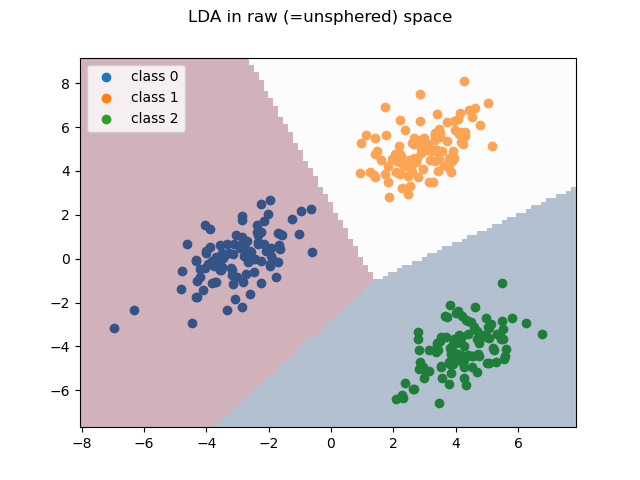

In [8]:
plt.figure()
plt.suptitle('LDA in raw (=unsphered) space')

# plot raw data points
for i, xk in enumerate(x):
    plt.scatter(xk[:, 0], xk[:, 1], label=f'class {i}')

DecisionBoundaryDisplay.from_estimator(
    lda,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    ax=plt.gca(),
    cmap="RdBu",
    alpha=0.3)
plt.legend()
plt.show()

## Quadratic Discriminant Analysis (QDA)

## Generate data

In [9]:
# set parameters
n = 100
mu = [np.array([-3, 0]), 
      np.array([3, 5]), 
      np.array([4, -4])]
sigma = [1, 0.5, 1.5]
rho = [-0.5, 0.5, 0.2]
cov = [np.array([[1,r],[r,1]])*s for r,s in zip(rho,sigma)]

# generate data
np.random.seed(2)
x = [ss.multivariate_normal(mean=m, cov=c).rvs(size=n) for m,c in zip(mu,cov)]
means_empiric = [xx.mean(axis=0) for xx in x] # for later validation
cov_empiric = [np.cov(xx.T, bias=True) for xx in x]
X = np.vstack(x)
y = np.hstack([np.ones(n)*0, np.ones(n)*1, np.ones(n)*2]).astype(int)

In [10]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X,y)

QuadraticDiscriminantAnalysis(store_covariance=True)

### Generate some new data for predictions

In [11]:
x_pred = np.array([[-2, 1], 
                   [0.5, 5], 
                   [4, -1], 
                   [0.3, 0.8]])

### Reconcile QDA calculations

In [12]:
# means
assert_array_almost_equal(qda.means_, means_empiric)

# priors
priors = np.array([ (y==i).sum() for i in range(3) ]) / X.shape[0]
assert_array_almost_equal(qda.priors_, priors)

# class covariances
for sigma_qda, x_class in zip(qda.covariance_, x):
    assert_array_almost_equal(sigma_qda, np.cov(x_class.T))
    
# quadratic discriminant log(P[y=k \mid x] = delta_k(x)
assert_array_almost_equal(
    qda.decision_function(x_pred),  # (n_test, n_classes)
    np.array([[- (qda.means_[k,:]-x_pred[l, :]).T @ np.linalg.inv(qda.covariance_[k]) @ (qda.means_[k,:]-x_pred[l, :]) /2 + np.log(priors[k]) - np.log(np.linalg.det(qda.covariance_[k]))/2 
               for k in range(3)] 
              for l in range(x_pred.shape[0])]))

# class prediction as argmax
assert_array_almost_equal(qda.predict(x_pred),  # (n_test, n_classes)
                          np.argmax(qda.decision_function(x_pred), axis=1))

### Plot results

<IPython.core.display.Javascript object>


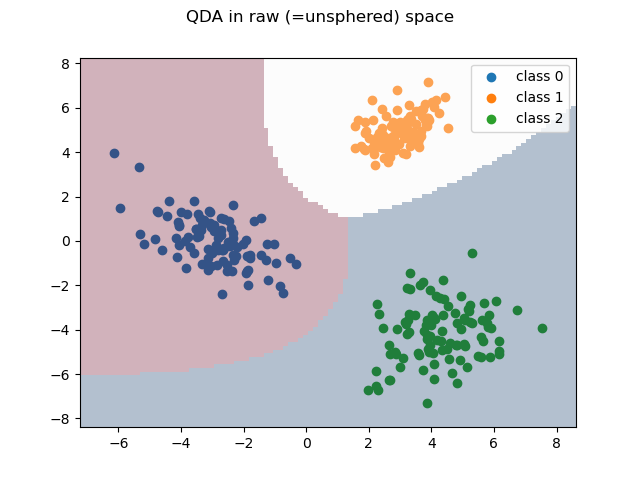

In [13]:
plt.figure()
plt.suptitle('QDA in raw (=unsphered) space')

# plot raw data points
for i, xk in enumerate(x):
    plt.scatter(xk[:, 0], xk[:, 1], label=f'class {i}')

DecisionBoundaryDisplay.from_estimator(
    qda,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    ax=plt.gca(),
    cmap="RdBu",
    alpha=0.3)
plt.legend()
plt.show()

## Comparison
We compare Gaussian Naive Bayes (GNB) with Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA) and Regularized Discriminant Analysis (RDA) on four data sets, all of which having $d=2$ features, and we assume that $X \mid Y=k$ is Gaussian and

1. independent with same variance for all classes
2. independent with different variance for all classes
2. not independent with same covariance matrix for all classes
3. not independent with different covariance matrix for all classes

### Dataset

In [18]:
# set parameters
n = 100
mu = [np.array([-3, 0]), 
      np.array([3, 5]), 
      np.array([4, -4])]
sigma = [1, 0.2, 2]
rho = [-0.5, 0.5, 0.2]
cov = [np.array([[1,r],[r,1]])*s for r,s in zip(rho,sigma)]

# generate data
np.random.seed(2)
X0 = np.vstack([ss.multivariate_normal(mean=m, cov=np.ones(2)).rvs(size=n) for m in mu])
X1 = np.vstack([ss.multivariate_normal(mean=m, cov=np.ones(2)*s).rvs(size=n) for m, s in zip(mu,sigma)])
X2 = np.vstack([ss.multivariate_normal(mean=m, cov=cov[0]).rvs(size=n) for m in mu])
X3 = np.vstack([ss.multivariate_normal(mean=m, cov=c).rvs(size=n) for m,c in zip(mu,cov)])
X = [X0, X1, X2, X3]
y = np.hstack([np.ones(n)*0, np.ones(n)*1, np.ones(n)*2]).astype(int)

# for easy indexation
i0 = np.zeros(3*n).astype(bool)
i1 = np.zeros(3*n).astype(bool)
i2 = np.zeros(3*n).astype(bool)
i0[:100]=True
i1[100:200]=True
i2[200:]=True
iclasses = [i0, i1, i2]

<IPython.core.display.Javascript object>


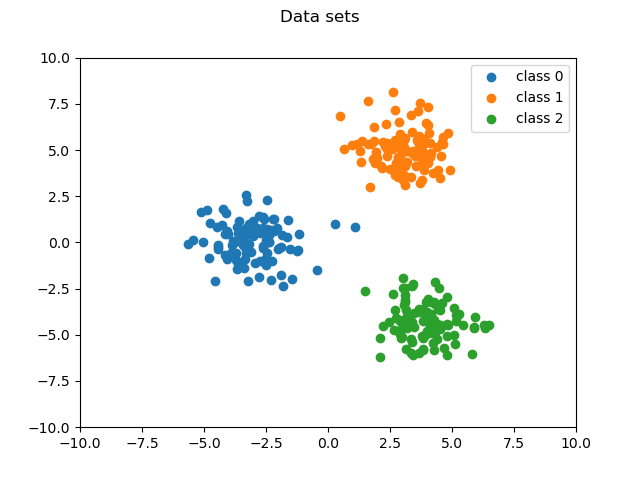

interactive(children=(IntSlider(value=0, description='dataset', max=3), Output()), _dom_classes=('widget-inter…

In [19]:
# plot data set

fig_data, ax_data = plt.subplots()
fig_data.suptitle('Data sets')

@wd.interact(dataset=wd.IntSlider(min=0, max=3, value=0))
def plot_data(dataset):
    ax_data.clear()
    for i, ic in enumerate(iclasses):
        plt.scatter(X[dataset][ic, 0], X[dataset][ic, 1], label=f'class {i}')
    ax_data.set_xlim([-10, 10])
    ax_data.set_ylim([-10, 10])
    ax_data.legend()

### Setup and train models

In [20]:
X_split = [train_test_split(X[i], y, shuffle=True, random_state=1, train_size=0.8) for i in range(4)]

models = []
for i in range(4):
    X_train, _, y_train, _ = X_split[i]
    gnb = GaussianNB()
    gnb.fit(X_train,y_train)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train,y_train)
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train,y_train)
    rda = QuadraticDiscriminantAnalysis(reg_param=0.9)
    rda.fit(X_train,y_train)
    models.append([gnb, lda, qda, rda])

### Plot decision boundaries

<IPython.core.display.Javascript object>


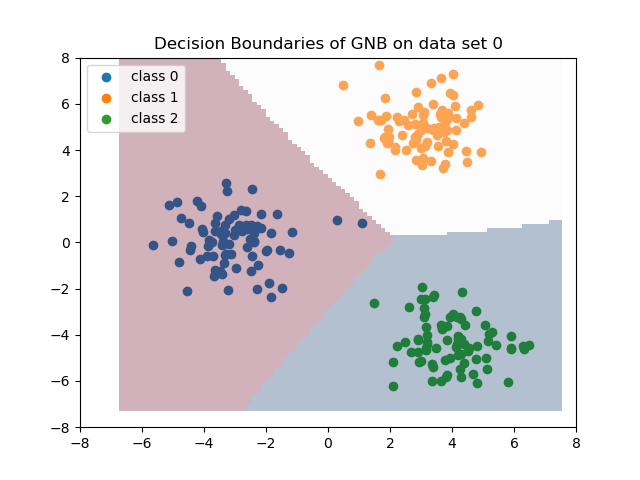

interactive(children=(IntSlider(value=0, description='ds_idx', max=3), IntSlider(value=0, description='model_i…

In [21]:
model_labels = ['GNB', 'LDA', 'QDA', 'RDA']

fig_dec, ax_dec = plt.subplots()

@wd.interact(ds_idx=wd.IntSlider(min=0, max=3, value=0),
           model_idx=wd.IntSlider(min=0, max=3, value=0))
def plot_decision_boundaries(ds_idx, model_idx):
    ax_dec.clear()
    ax_dec.set_title(f'Decision Boundaries of {model_labels[model_idx]} on data set {ds_idx}')
    ax_dec.set_xlim([-8,8])
    ax_dec.set_ylim([-8,8])
    
    x_train, _, y_train, _ = X_split[ds_idx]
    model = models[ds_idx][model_idx]
    for i in range(3):
        xk = x_train[y_train==i]
        ax_dec.scatter(xk[:, 0], xk[:, 1], label=f'class {i}')
    DecisionBoundaryDisplay.from_estimator(
        model,
        x_train,
        response_method="predict",
        plot_method="pcolormesh",
        ax=ax_dec,
        cmap="RdBu",
        alpha=0.3)
    plt.legend()
    plt.show()

# Sources & References

* Hastie, Tibshani, Friedman. *The Elements of Statistical Learning*, Chapter 4
* https://scikit-learn.org/stable/api/sklearn.discriminant_analysis.html
* https://scikit-learn.org/stable/modules/lda_qda.html
* https://en.wikipedia.org/wiki/Voronoi_diagram
* https://www.cse.iitk.ac.in/users/amit/courses/RMP/presentations/kshitij/index.html